In [1]:
import numpy as np
import torch
import torch.nn as nn
from utils import FakeDL, eigenspace_stability
import algos.pyhessian as pyhessian 

import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.use('Agg')

from phicomp import comp_phi

device = "cpu"

In [2]:
def get_dataset(n, d):
    # assert n >= d
    X = np.sqrt(n) * torch.qr(torch.normal(torch.zeros(n, d)))[0]

    # Can be changed to sqrt(d) * I as suggested
    # A = torch.normal(torch.zeros(d, d))
    A = torch.eye(d) * np.sqrt(d)
    # A = torch.eye(d)
    Y = torch.matmul(X, A)
    return X, Y

In [3]:
class LinearNet(nn.Module):
    def __init__(self, L, d):
        super(LinearNet, self).__init__()
        self.L = L
        self.layers = []
        for i in range(L):
            # For dimension debugging
            # if i == L - 1:
            #     self.layers.append(nn.Linear(d + i * 1, d, bias=False))
            # else:
            #     self.layers.append(nn.Linear(d + i * 1, d + (i + 1) * 1, bias=False))
            self.layers.append(nn.Linear(d, d, bias=False))
            self.add_module("W{}".format(i+1), self.layers[-1])

    def forward(self, x):
        for i in range(self.L):
            x = self.layers[i](x)
        return x

In [4]:
def compute_eigeninfo(net, dl, topn, criterion):
    # Computing the top n eigenvectors using Power Iteration Method.
    net.eval()
    hessian_comp = pyhessian.hessian(net, criterion, dataloader=dl, cuda=False if device=="cpu" else True)
    eigenvals, eigenvecs = hessian_comp.eigenvalues(top_n=topn, tol=1e-4, maxIter=1000)
    # print(eigenvals)
    net.train()
    return eigenvals, eigenvecs

def quadratic_loss(Y_hat, Y):
    """Batched quadratic loss"""
    diff = torch.square(Y - Y_hat)
    loss = diff.sum() * 0.5
    if len(Y_hat.shape) != 1:
        loss /= len(Y)
    return loss

In [5]:
def train(X, Y, L, d, eta, epochs, hessian_eval_epochs, hessian_topn, save_eigenvecs=True):
    """
    X, Y : dataset
    L, d : as defined in the paper
    epochs : total number of epochs to train
    hessian_eval_epochs : list of integers indicating on which epochs to calculate the eigeninformation
    hessian_topn : number of top eigenvector/values to compute
    save_eigenvecs : whether to save the eigenvectors
    """

    # Dataloader for Hessian Calculation
    dataloader = FakeDL(X, Y, device)
    loss_record = []
    eigenvals_record = []
    eigenvecs_record = []

    net = LinearNet(L, d).to(device)
    # Xavier Initialization
    # for param in net.parameters():
    #     param.data = torch.normal(torch.zeros_like(param), 1/np.sqrt(d)) # pylint: disable=no-member
    for layer in net.layers:
        nn.init.xavier_normal_(layer.weight)
    
    # criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(net.parameters(), lr=eta)

    for epoch in range(epochs):  # loop over the dataset multiple times
        optimizer.zero_grad()
        
        Y_hat = net(X)
        # loss = criterion(Y_hat, Y)
        loss = quadratic_loss(Y_hat, Y)
        # exit()
        
        loss.backward()
        optimizer.step()
        
        loss_record.append(loss.item())

        if epoch in hessian_eval_epochs:
            eigenvals, eigenvecs = compute_eigeninfo(net, dataloader, hessian_topn, quadratic_loss)
            eigenvals_record.append(eigenvals)
            if save_eigenvecs:
                eigenvecs_record.append(eigenvecs)

            Ws = [W.weight.data for W in net.layers]
            W_prod = Ws[0].clone()
            for W in Ws[1:]:
                W_prod = W.matmul(W_prod)

            # Alternative loss computation (squared fro norm of difference between weight and A)
            loss_alter = (W_prod - torch.eye(d) * np.sqrt(d)).square().sum() / 2

            # Phi and flattest hessian availble here
            # Phi = comp_phi(Ws)
            # H_flattest_min = Phi.matmul(Phi.T) # (since we are using the loss function from 2103.00065 with a half)
            # print(H_flattest_min.shape)

        if epoch % 100 == 0:
            print("Epoch {} \t Loss: {:.6g} \t Sharpness: {:.6g}".format(epoch, loss.item(), eigenvals_record[-1][0] if len(eigenvals_record) > 0 else -1))

    return loss_record, eigenvals_record, eigenvecs_record

In [21]:
def visualize(loss_record, hessian_eval_epochs, eigenvals_record, eigenvecs_record, eta, title):

    e_start = hessian_eval_epochs[0]
    e_end = hessian_eval_epochs[-1]

    shift = 1 if len(eigenvecs_record) != 0 else 0

    # Plot the empirical loss
    plt.figure(figsize=(8, 15))
    plt.suptitle(title)
    plt.subplot(211 + 100 * shift)
    plt.title(r"Training Loss $\eta$={:.4g}".format(eta))
    plt.plot(np.arange(len(loss_record))[e_start:e_end], loss_record[e_start:e_end], label=r'$\eta$={:.4g}'.format(eta))
    plt.xlabel('Epochs')

    # Plot the eigenvalues
    plt.subplot(212 + 100 * shift)
    plt.axhline(y=2/eta, linestyle=':')
    plt.title(r"Top eigenvalues $\eta$={:.4g}".format(eta))
    for k in range(len(eigenvals_record[0])):
        plt.scatter(hessian_eval_epochs, [v[k] for v in eigenvals_record], label=r'$\lambda_{}$'.format(k+1))
    plt.xlabel('Epochs')

    if len(eigenvecs_record) != 0:
        plt.subplot(313)
        eigenspace_ovlp = eigenspace_stability(eigenvecs_record)
        plt.suptitle(title)
        plt.title(r"Eigenspace Overlap $\eta$={:.4g}".format(eta))
        for k in range(len(eigenspace_ovlp)):
            plt.scatter(hessian_eval_epochs[1:], eigenspace_ovlp[k][1:], label='top {} eigenspace'.format(k+1))
        plt.xlabel('Epochs')

    plt.legend()
    plt.show()
    plt.savefig('./figs/{}_eta{:.4g}_epochs{}_eigenvals.jpg'.format(title, eta, len(loss_record)))

Epoch 0 	 Loss: 74.2584 	 Sharpness: -1
Epoch 100 	 Loss: 29.7952 	 Sharpness: -1
Epoch 200 	 Loss: 25.2172 	 Sharpness: -1
Epoch 300 	 Loss: 24.9394 	 Sharpness: -1
Epoch 400 	 Loss: 24.8178 	 Sharpness: -1
Epoch 500 	 Loss: 24.4986 	 Sharpness: -1
Epoch 600 	 Loss: 20.0402 	 Sharpness: -1
Epoch 700 	 Loss: 19.9981 	 Sharpness: -1
Epoch 800 	 Loss: 19.9975 	 Sharpness: -1
Epoch 900 	 Loss: 19.9969 	 Sharpness: -1
Epoch 1000 	 Loss: 19.9962 	 Sharpness: -1
Epoch 1100 	 Loss: 19.9954 	 Sharpness: -1
Epoch 1200 	 Loss: 19.9944 	 Sharpness: -1
Epoch 1300 	 Loss: 19.9932 	 Sharpness: -1
Epoch 1400 	 Loss: 19.9916 	 Sharpness: -1
Epoch 1500 	 Loss: 19.9895 	 Sharpness: -1
Epoch 1600 	 Loss: 19.9866 	 Sharpness: -1
Epoch 1700 	 Loss: 19.9824 	 Sharpness: -1
Epoch 1800 	 Loss: 19.9759 	 Sharpness: -1
Epoch 1900 	 Loss: 19.9648 	 Sharpness: -1
Epoch 2000 	 Loss: 19.9426 	 Sharpness: -1
Epoch 2100 	 Loss: 19.8829 	 Sharpness: -1
Epoch 2200 	 Loss: 19.5341 	 Sharpness: 979.188
Epoch 2300 	 Loss:

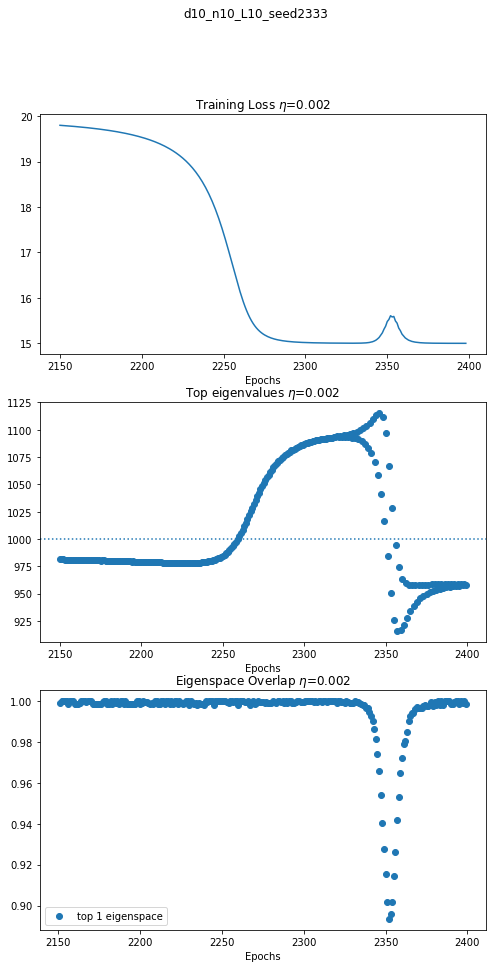

<Figure size 432x288 with 0 Axes>

In [22]:
seed, eval_start, eval_end = 0, 2250, 2400
seed, eval_start, eval_end = 2333, 2150, 2400
freq = 1

torch.manual_seed(seed)
# Configs, current set as proposed in the paper
d = 10 # layer width
n = 10 # # of samples
L = 10 # # of layers

X, Y = get_dataset(n, d)
X, Y = X.to(device), Y.to(device)

eta = 2/1000
epochs = eval_end
hessian_eval_epochs = list(range(eval_start, eval_end, freq))

train_result = train(X, Y, L, d, eta, epochs, hessian_eval_epochs, hessian_topn=1, save_eigenvecs=True)
loss_record, eigenvals_record, eigenvecs_record = train_result

title = "d{}_n{}_L{}_seed{}".format(d, n, L, seed)
visualize(loss_record, hessian_eval_epochs, eigenvals_record, eigenvecs_record, eta, title)

Epoch 0 	 Loss: 50.4724 	 Sharpness: -1
Epoch 100 	 Loss: 30.3997 	 Sharpness: -1
Epoch 200 	 Loss: 24.0534 	 Sharpness: -1
Epoch 300 	 Loss: 20.0016 	 Sharpness: -1
Epoch 400 	 Loss: 20.0005 	 Sharpness: -1
Epoch 500 	 Loss: 19.9998 	 Sharpness: -1
Epoch 600 	 Loss: 19.999 	 Sharpness: -1
Epoch 700 	 Loss: 19.9982 	 Sharpness: -1
Epoch 800 	 Loss: 19.9973 	 Sharpness: -1
Epoch 900 	 Loss: 19.9964 	 Sharpness: -1
Epoch 1000 	 Loss: 19.9953 	 Sharpness: -1
Epoch 1100 	 Loss: 19.9941 	 Sharpness: -1
Epoch 1200 	 Loss: 19.9927 	 Sharpness: -1
Epoch 1300 	 Loss: 19.991 	 Sharpness: -1
Epoch 1400 	 Loss: 19.9889 	 Sharpness: -1
Epoch 1500 	 Loss: 19.9863 	 Sharpness: -1
Epoch 1600 	 Loss: 19.9828 	 Sharpness: -1
Epoch 1700 	 Loss: 19.9781 	 Sharpness: -1
Epoch 1800 	 Loss: 19.9713 	 Sharpness: -1
Epoch 1900 	 Loss: 19.9607 	 Sharpness: -1
Epoch 2000 	 Loss: 19.9422 	 Sharpness: -1
Epoch 2100 	 Loss: 19.9035 	 Sharpness: -1
Epoch 2200 	 Loss: 19.7874 	 Sharpness: -1
Epoch 2300 	 Loss: 18.750

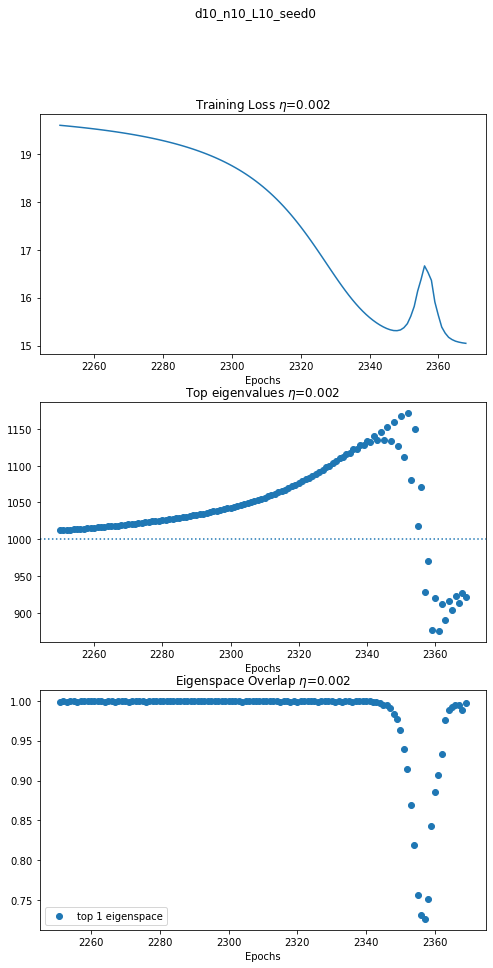

<Figure size 432x288 with 0 Axes>

In [24]:
seed, eval_start, eval_end = 0, 2250, 2370
freq = 1

torch.manual_seed(seed)
# Configs, current set as proposed in the paper
d = 10 # layer width
n = 10 # # of samples
L = 10 # # of layers

X, Y = get_dataset(n, d)
X, Y = X.to(device), Y.to(device)

eta = 2/1000
epochs = eval_end
hessian_eval_epochs = list(range(eval_start, eval_end, freq))

train_result = train(X, Y, L, d, eta, epochs, hessian_eval_epochs, hessian_topn=1, save_eigenvecs=True)
loss_record, eigenvals_record, eigenvecs_record = train_result

title = "d{}_n{}_L{}_seed{}".format(d, n, L, seed)
visualize(loss_record, hessian_eval_epochs, eigenvals_record, eigenvecs_record, eta, title)

Epoch 0 	 Loss: 237.111 	 Sharpness: -1
Epoch 100 	 Loss: 147.603 	 Sharpness: -1
Epoch 200 	 Loss: 136.885 	 Sharpness: -1
Epoch 300 	 Loss: 129.996 	 Sharpness: -1
Epoch 400 	 Loss: 129.988 	 Sharpness: -1
Epoch 500 	 Loss: 129.969 	 Sharpness: -1
Epoch 600 	 Loss: 129.858 	 Sharpness: -1
Epoch 700 	 Loss: 120.02 	 Sharpness: -1
Epoch 800 	 Loss: 120.001 	 Sharpness: -1
Epoch 900 	 Loss: 120.001 	 Sharpness: -1
Epoch 1000 	 Loss: 120 	 Sharpness: -1
Epoch 1100 	 Loss: 120 	 Sharpness: -1
Epoch 1200 	 Loss: 120 	 Sharpness: -1
Epoch 1300 	 Loss: 120 	 Sharpness: -1
Epoch 1400 	 Loss: 119.999 	 Sharpness: -1
Epoch 1500 	 Loss: 119.999 	 Sharpness: -1
Epoch 1600 	 Loss: 119.999 	 Sharpness: -1
Epoch 1700 	 Loss: 119.998 	 Sharpness: -1
Epoch 1800 	 Loss: 119.998 	 Sharpness: -1
Epoch 1900 	 Loss: 119.997 	 Sharpness: -1
Epoch 2000 	 Loss: 119.996 	 Sharpness: -1
Epoch 2100 	 Loss: 119.995 	 Sharpness: -1
Epoch 2200 	 Loss: 119.993 	 Sharpness: -1
Epoch 2300 	 Loss: 119.99 	 Sharpness: -

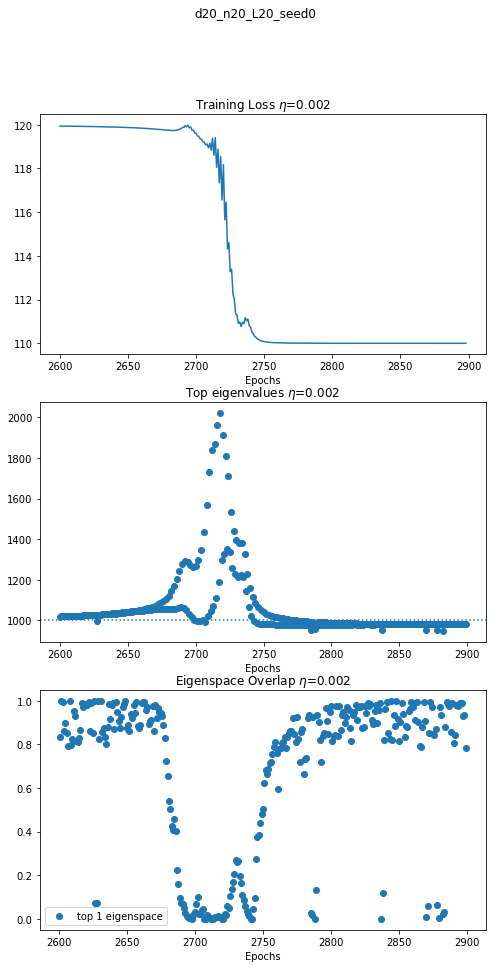

<Figure size 432x288 with 0 Axes>

In [29]:
seed, eval_start, eval_end = 0, 2600, 2900
freq = 1

torch.manual_seed(seed)
# Configs, current set as proposed in the paper
d = 20 # layer width
n = 20 # # of samples
L = 20 # # of layers

X, Y = get_dataset(n, d)
X, Y = X.to(device), Y.to(device)

eta = 2/1000
epochs = eval_end
hessian_eval_epochs = list(range(eval_start, eval_end, freq))

train_result = train(X, Y, L, d, eta, epochs, hessian_eval_epochs, hessian_topn=1, save_eigenvecs=True)
loss_record, eigenvals_record, eigenvecs_record = train_result

title = "d{}_n{}_L{}_seed{}".format(d, n, L, seed)
visualize(loss_record, hessian_eval_epochs, eigenvals_record, eigenvecs_record, eta, title)

Epoch 0 	 Loss: 237.111 	 Sharpness: -1
Epoch 100 	 Loss: 147.603 	 Sharpness: -1
Epoch 200 	 Loss: 136.885 	 Sharpness: -1
Epoch 300 	 Loss: 129.996 	 Sharpness: -1
Epoch 400 	 Loss: 129.988 	 Sharpness: -1
Epoch 500 	 Loss: 129.969 	 Sharpness: -1
Epoch 600 	 Loss: 129.858 	 Sharpness: 946.329
Epoch 700 	 Loss: 120.02 	 Sharpness: 984.131


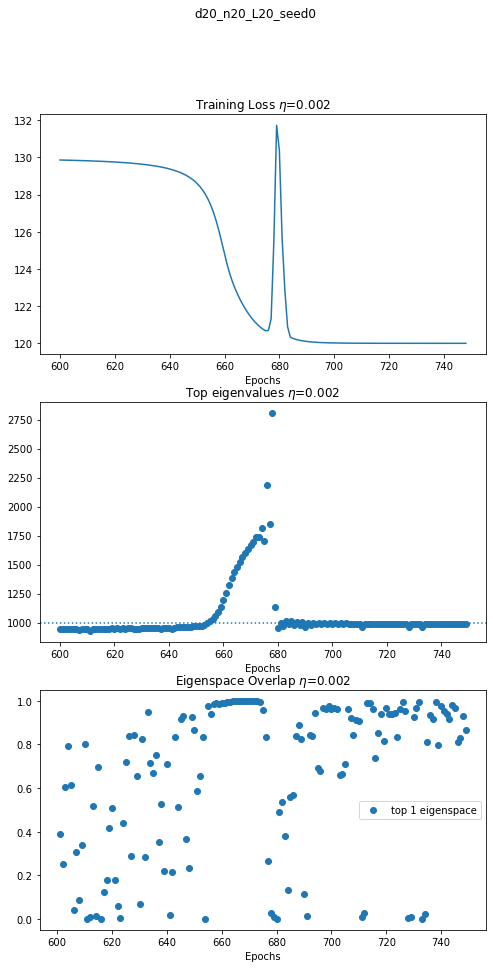

<Figure size 432x288 with 0 Axes>

In [31]:
seed, eval_start, eval_end = 0, 600, 750
freq = 1

torch.manual_seed(seed)
# Configs, current set as proposed in the paper
d = 20 # layer width
n = 20 # # of samples
L = 20 # # of layers

X, Y = get_dataset(n, d)
X, Y = X.to(device), Y.to(device)

eta = 2/1000
epochs = eval_end
hessian_eval_epochs = list(range(eval_start, eval_end, freq))

train_result = train(X, Y, L, d, eta, epochs, hessian_eval_epochs, hessian_topn=1, save_eigenvecs=True)
loss_record, eigenvals_record, eigenvecs_record = train_result

title = "d{}_n{}_L{}_seed{}".format(d, n, L, seed)
visualize(loss_record, hessian_eval_epochs, eigenvals_record, eigenvecs_record, eta, title)